# Vehicle Detection and Tracking

[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


The Project
---

In this project, your goal is to write a software pipeline to detect and track vehicles in a video.  


The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

This labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) are used to train the classifier. These  images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself. A futher data source is the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations).  



# Viszalize

In [1]:
import glob

car_image_paths    = glob.glob('data/vehicles/**/*.png')
noncar_image_paths = glob.glob('data/non-vehicles/**/*.png')
test_image_paths   = glob.glob('test_images/*.jpg')

visualize = False

import cv2
import matplotlib.pyplot as plt
from lesson_functions import *

def load_image(path,conv=cv2.COLOR_BGR2YCrCb):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, conv)
    return img

if visualize:
    for path in car_image_paths[::4000]+noncar_image_paths[::4000]+test_image_paths:
        print(path)
        plt.imshow(load_image(path,conv=cv2.COLOR_BGR2RGB))
        plt.show()


# Histogram of Oriented Gradients (HOG)


Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.
	

Explanation given for methods used to extract HOG features, including which color space was chosen, which HOG parameters (orientations, pixels_per_cell, cells_per_block), and why. 


In [2]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

if visualize:
    for path in car_image_paths[::4000]+noncar_image_paths[::4000]:
        print(path)
        img = load_image(path)[:,:,0]
        print(img.shape)

        features, hog_image = get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

        # Plot
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(img, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(122)
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG Visualization')
        plt.show()



# Stacked Features

In [3]:
spatial_size = (32, 32)
hist_bins = 32

if visualize:
    for path in car_image_paths[::4000]+noncar_image_paths[::4000]:
        print(path)
        img = load_image(path,conv=cv2.COLOR_BGR2RGB)
        print(img.shape)

        X_unscaled = get_features(img, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
                
        # Plot
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(img, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(122)
        plt.plot(X_unscaled[0])
        plt.title('Feature Visualization')
        plt.show()




# Normalize

In [4]:
import sys
import pickle


X_path = car_image_paths + noncar_image_paths
y      = np.hstack((np.ones(len(car_image_paths)), np.zeros(len(noncar_image_paths))))

#reduce dataset for normalize and train due comutation limits / peak working set ~4GB
data_set_reduce_to = len(X_path)//2
X_path = X_path[::len(X_path)//data_set_reduce_to] 
y      = y[::len(y)//data_set_reduce_to]

print(len(X_path))
print(len(y))




try:
    with open('X_scaler.p', 'rb') as handle:
        X_scaler = pickle.load(handle)
except:
    X_scalers = []
    for i,path in enumerate(X_path):
        #print(i,'of',len(path),end='')
        sys.stdout.write("Progress: %d of %d | %f%%   \r" % (i+1,len(X_path),(i+1)/len(X_path)*100 ))
        sys.stdout.flush()
        img = load_image(path,conv=cv2.COLOR_BGR2RGB)
        X_unscaled = get_features(img, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        X_scalers.append(X_unscaled[0])
    print('')
    %time X_scaler = StandardScaler().fit(X_scalers)
    #del X_scalers
    with open('X_scaler.p', 'wb') as handle:
        pickle.dump(X_scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

8880
8880


In [5]:


if visualize:
    for path in car_image_paths[::4000]+noncar_image_paths[::4000]:
        print(path)
        img = load_image(path,conv=cv2.COLOR_BGR2RGB)
        print(img.shape)

        X_unscaled = get_features(img, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        print(X_unscaled.shape)
        X_scaled = X_scaler.transform(X_unscaled)
 
        # Plot
        fig = plt.figure(figsize=(12, 6))
        plt.subplot(131)
        plt.imshow(img, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(132)
        plt.plot(X_unscaled[0])
        plt.title('X_unscaled')
        plt.subplot(133)
        plt.plot(X_scaled[0])
        plt.title('X_scaled')
        plt.show()


# Classify

Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).
	

The HOG features extracted from the training data have been used to train a classifier, could be SVM, Decision Tree or other. Features should be scaled to zero mean and unit variance before training the classifier.


## Split

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

test_size=1/11

X_train_paths, X_test_paths, y_train, y_test = train_test_split(X_path, y, test_size=test_size, random_state=42)

def load_data(paths):
    result = []
    for i,path in enumerate(paths):
        #print(i,'of',len(path),end='')
        sys.stdout.write("Progress: %d of %d | %f%%   \r" % (i+1,len(paths),(i+1)/len(paths)*100 ))
        sys.stdout.flush()
        img = load_image(path,conv=cv2.COLOR_BGR2RGB)
        X_unscaled = get_features(img, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        X_scaled = X_scaler.transform(X_unscaled).reshape(-1)#.reshape(1, -1)
        result.append(X_scaled)

    print('')
    return np.array(result)[:,:]


try:
    with open('X_train.p', 'rb') as handle:
        X_train = pickle.load(handle)
    assert len(X_train) == len(y_train)
except:
    X_train =  load_data(X_train_paths)
    with open('X_train.p', 'wb') as handle:
        pickle.dump(X_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
try:
    with open('X_test.p', 'rb') as handle:
        X_test = pickle.load(handle)
    assert len(X_test) == len(y_test)
except:
    X_test  =  load_data(X_test_paths)    
    with open('X_test.p', 'wb') as handle:
        pickle.dump(X_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

#print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)

In [7]:
if visualize:
    for i in range(10):
        path = X_train_paths[i]
        print(path)
        img = load_image(path,conv=cv2.COLOR_BGR2RGB)
        print(img.shape)
        
        X = X_train[i]
        
        # Plot
        fig = plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.imshow(img, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(122)
        plt.plot(X)
        plt.title('X')
        plt.show()


## Train

In [8]:
import time
from sklearn.svm import LinearSVC


# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test  Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

7.09 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test  Accuracy of SVC =  0.9839
My SVC predicts:      [ 0.  0.  1.  1.  1.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  0.  1.  1.  0.  1.]
0.0 Seconds to predict 10 labels with SVC


# Sliding Window Search

Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?
	

A sliding window approach has been implemented, where overlapping tiles in each test image are classified as vehicle or non-vehicle. Some justification has been given for the particular implementation chosen.


In [9]:
ystart = 400
ystop = 656
scale = 1.5

class Frame_Prozessor:
    
    def __init__(self):
        self.shape = (720, 1280)
        self.background = np.zeros(self.shape)
        
        self.smooth_heatmap = np.zeros(self.shape)
        self.smoothing = 0.95
        
    def calc_heatmap(self,bbox_list,img=None,heatmap_threshold = 7):
        if img == None:
            img = np.empty(self.shape)
        heatmap = add_heat(img, bbox_list)
        heatmap = apply_threshold(heatmap, heatmap_threshold)
        return heatmap
        
    def add_background(self,img):
        draw_img,bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        self.background = self.background + self.calc_heatmap(bbox_list)
        self.background_max = np.max(self.background)
        print('self.background_max = ',self.background_max)
        # Output Prozessing
        self.background_normalized = self.background/self.background_max
        self.background_normalized_gray = np.uint8(self.background_normalized/self.background_max*255)
        self.background_normalized_gray = cv2.cvtColor(self.background_normalized_gray, cv2.COLOR_GRAY2RGB)
        result  = cv2.addWeighted(self.background_normalized_gray, 0.75, draw_img, 0.25, 0)
        return result
    
    def add_smooth_heatmap(self,heatmap,img=None):
        if img == None:
            img = np.empty((self.shape[0],self.shape[1],3))
        self.smooth_heatmap = cv2.addWeighted(self.smooth_heatmap, self.smoothing, heatmap, 1-self.smoothing, 0)
        # Output Prozessing
        smooth_heatmap_max = np.max(heatmap)
        print('smooth_heatmap_max = ',smooth_heatmap_max)
        self.smooth_heatmap_normalized = self.smooth_heatmap/smooth_heatmap_max*255
        heatmap_normalized = heatmap/np.max(heatmap)*255
        smooth_heatmap_color = np.dstack([heatmap_normalized, self.smooth_heatmap_normalized, np.empty(self.shape)])
        result  = cv2.addWeighted(np.uint8(smooth_heatmap_color), 0.75, np.uint8(img), 0.25, 0)
        return result
    
    def visualize_frame(self,img):
        draw_img,bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        heatmap = self.calc_heatmap(bbox_list)
        result = self.add_smooth_heatmap(heatmap,draw_img)
        return result,draw_img,heatmap
    
    def process_frame(self,img):
        result,draw_img,heatmap = self.visualize_frame(img)
        plt.imshow(result, cmap='gray')
        plt.show()
        return result
    
frame_prozessor = Frame_Prozessor()




test_images\test1.jpg
(720, 1280, 3)


C:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


smooth_heatmap_max =  15.0


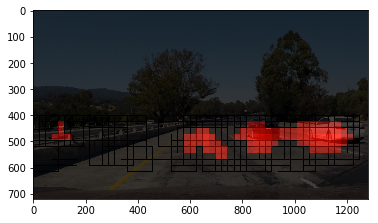

test_images\test2.jpg
(720, 1280, 3)
smooth_heatmap_max =  10.0


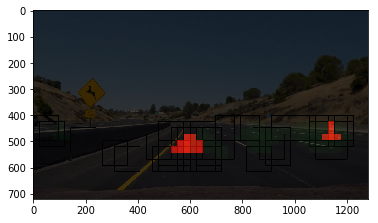

test_images\test3.jpg
(720, 1280, 3)
smooth_heatmap_max =  8.0


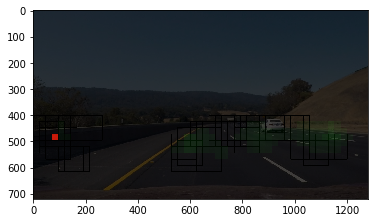

test_images\test4.jpg
(720, 1280, 3)
smooth_heatmap_max =  13.0


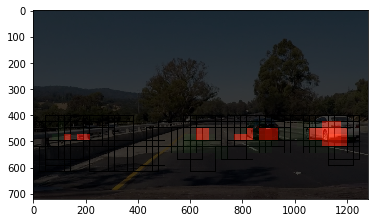

test_images\test5.jpg
(720, 1280, 3)
smooth_heatmap_max =  15.0


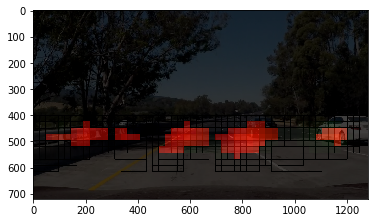

test_images\test6.jpg
(720, 1280, 3)
smooth_heatmap_max =  14.0


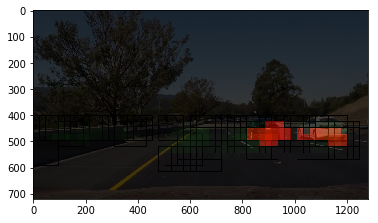

In [10]:
if visualize or True:
    for path in test_image_paths:
        print(path)
        img = load_image(path,conv=cv2.COLOR_BGR2RGB)
        print(img.shape)

        
        #background = frame_prozessor.add_background(img)
        #plt.imshow(background, cmap='gray')
        #plt.title('background')
        #plt.show()
        
        
        process_frame_result = frame_prozessor.process_frame(img)
        #plt.imshow(process_frame_result, cmap='gray')
        #plt.show()
            
        # Plot
        #fig = plt.figure(figsize=(16, 6))
        #plt.subplot(131)
        #plt.imshow(img, cmap='gray')
        #plt.title('Example Car Image')
        #plt.subplot(132)
        #plt.imshow(draw_img, cmap='gray')
        #plt.title('draw_img')
        #plt.subplot(133)
        #plt.imshow(result, cmap='gray')
        #plt.title('heatmap')
        #plt.show()
        #
        #

Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?
	

Some discussion is given around how you improved the reliability of the classifier i.e., fewer false positives and more reliable car detections (this could be things like choice of feature vector, thresholding the decision function, hard negative mining etc.)

# Video Implementation

Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
	

The sliding-window search plus classifier has been used to search for and identify vehicles in the videos provided. Video output has been generated with detected vehicle positions drawn (bounding boxes, circles, cubes, etc.) on each frame of video.

Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.
	

A method, such as requiring that a detection be found at or near the same position in several subsequent frames, (could be a heat map showing the location of repeat detections) is implemented as a means of rejecting false positives, and this demonstrably reduces the number of false positives. Same or similar method used to draw bounding boxes (or circles, cubes, etc.) around high-confidence detections where multiple overlapping detections occur. 

test_video.mp4
smooth_heatmap_max =  0.0


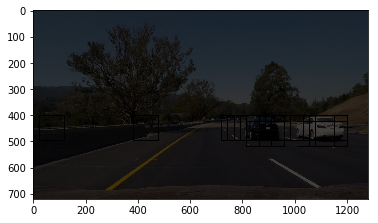

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

smooth_heatmap_max =  0.0


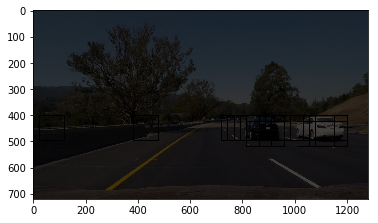

  3%|██▏                                                                                | 1/39 [00:01<00:57,  1.52s/it]

smooth_heatmap_max =  0.0


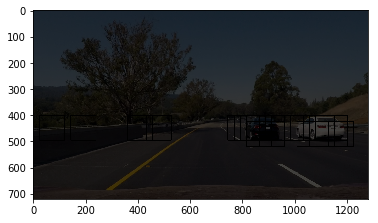

  5%|████▎                                                                              | 2/39 [00:02<00:54,  1.46s/it]

smooth_heatmap_max =  10.0


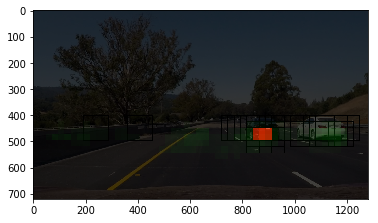

  8%|██████▍                                                                            | 3/39 [00:04<00:50,  1.41s/it]

smooth_heatmap_max =  9.0


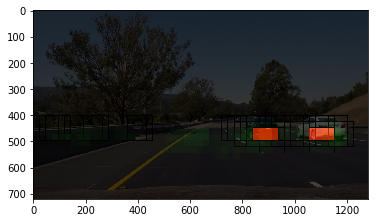

 10%|████████▌                                                                          | 4/39 [00:05<00:51,  1.47s/it]

smooth_heatmap_max =  10.0


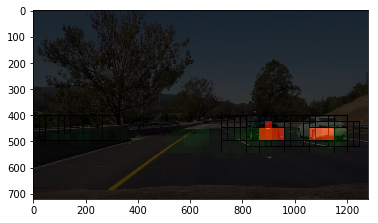

 13%|██████████▋                                                                        | 5/39 [00:07<00:49,  1.45s/it]

smooth_heatmap_max =  11.0


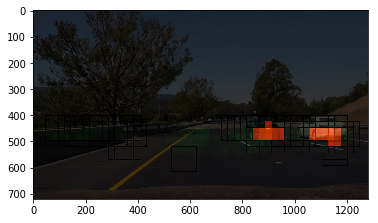

 15%|████████████▊                                                                      | 6/39 [00:08<00:47,  1.44s/it]

smooth_heatmap_max =  10.0


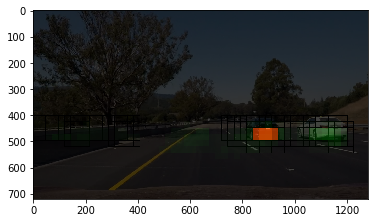

 18%|██████████████▉                                                                    | 7/39 [00:10<00:46,  1.44s/it]

smooth_heatmap_max =  10.0


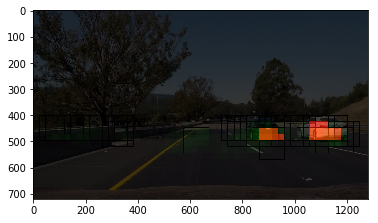

 21%|█████████████████                                                                  | 8/39 [00:11<00:44,  1.43s/it]

smooth_heatmap_max =  8.0


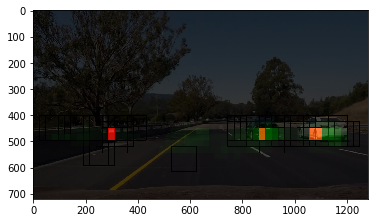

 23%|███████████████████▏                                                               | 9/39 [00:12<00:43,  1.45s/it]

smooth_heatmap_max =  10.0


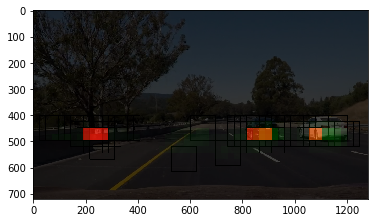

 26%|█████████████████████                                                             | 10/39 [00:14<00:42,  1.46s/it]

smooth_heatmap_max =  12.0


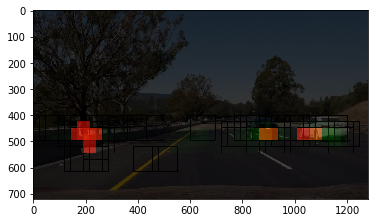

 28%|███████████████████████▏                                                          | 11/39 [00:15<00:41,  1.47s/it]

smooth_heatmap_max =  13.0


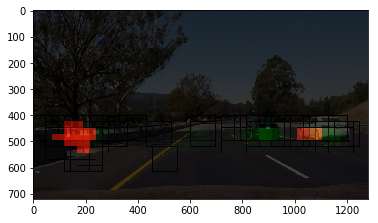

 31%|█████████████████████████▏                                                        | 12/39 [00:17<00:38,  1.44s/it]

smooth_heatmap_max =  12.0


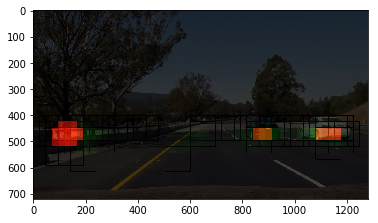

 33%|███████████████████████████▎                                                      | 13/39 [00:18<00:36,  1.41s/it]

smooth_heatmap_max =  12.0


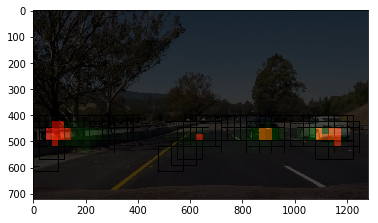

 36%|█████████████████████████████▍                                                    | 14/39 [00:19<00:34,  1.39s/it]

smooth_heatmap_max =  11.0


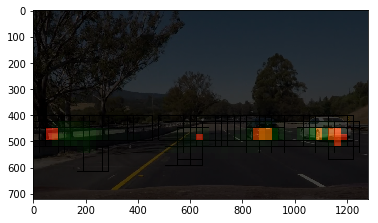

 38%|███████████████████████████████▌                                                  | 15/39 [00:21<00:33,  1.41s/it]

smooth_heatmap_max =  11.0


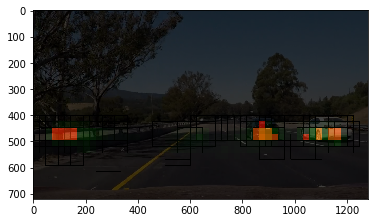

 41%|█████████████████████████████████▋                                                | 16/39 [00:22<00:31,  1.37s/it]

smooth_heatmap_max =  10.0


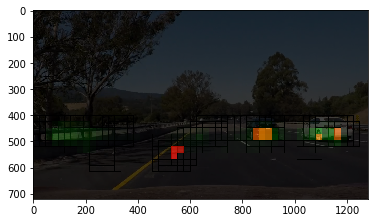

 44%|███████████████████████████████████▋                                              | 17/39 [00:24<00:30,  1.36s/it]

smooth_heatmap_max =  10.0


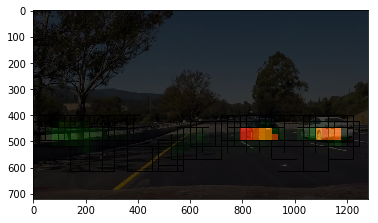

 46%|█████████████████████████████████████▊                                            | 18/39 [00:25<00:29,  1.39s/it]

smooth_heatmap_max =  10.0


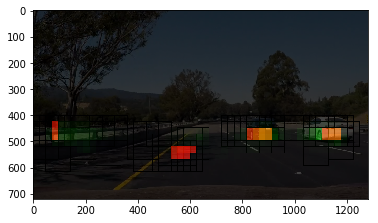

 49%|███████████████████████████████████████▉                                          | 19/39 [00:26<00:27,  1.40s/it]

smooth_heatmap_max =  11.0


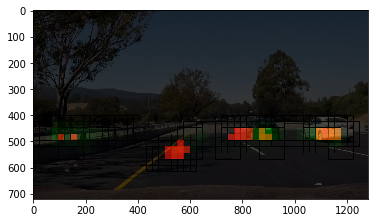

 51%|██████████████████████████████████████████                                        | 20/39 [00:28<00:25,  1.37s/it]

smooth_heatmap_max =  13.0


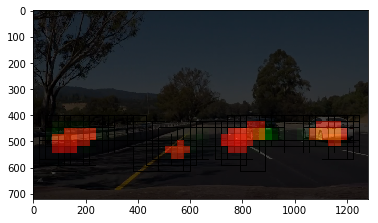

 54%|████████████████████████████████████████████▏                                     | 21/39 [00:29<00:24,  1.36s/it]

smooth_heatmap_max =  11.0


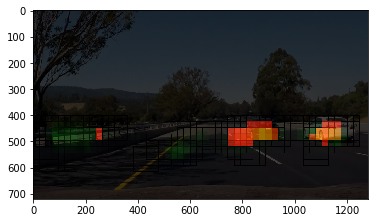

 56%|██████████████████████████████████████████████▎                                   | 22/39 [00:30<00:22,  1.35s/it]

smooth_heatmap_max =  11.0


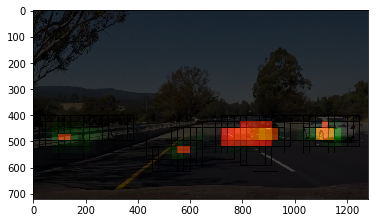

 59%|████████████████████████████████████████████████▎                                 | 23/39 [00:32<00:21,  1.35s/it]

smooth_heatmap_max =  12.0


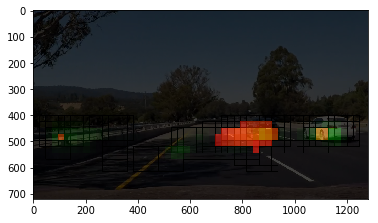

 62%|██████████████████████████████████████████████████▍                               | 24/39 [00:33<00:19,  1.33s/it]

smooth_heatmap_max =  12.0


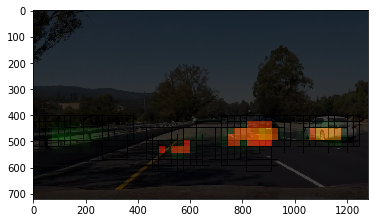

 64%|████████████████████████████████████████████████████▌                             | 25/39 [00:34<00:18,  1.30s/it]

smooth_heatmap_max =  10.0


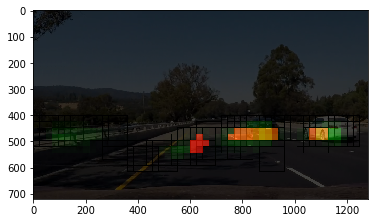

 67%|██████████████████████████████████████████████████████▋                           | 26/39 [00:36<00:16,  1.29s/it]

smooth_heatmap_max =  12.0


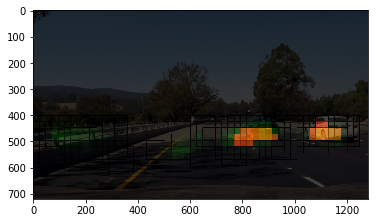

 69%|████████████████████████████████████████████████████████▊                         | 27/39 [00:37<00:15,  1.28s/it]

smooth_heatmap_max =  14.0


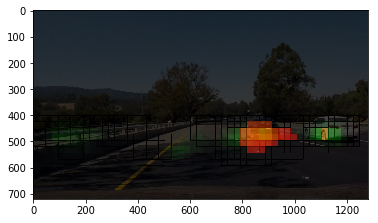

 72%|██████████████████████████████████████████████████████████▊                       | 28/39 [00:38<00:14,  1.33s/it]

smooth_heatmap_max =  14.0


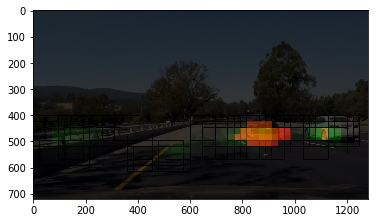

 74%|████████████████████████████████████████████████████████████▉                     | 29/39 [00:40<00:13,  1.34s/it]

smooth_heatmap_max =  12.0


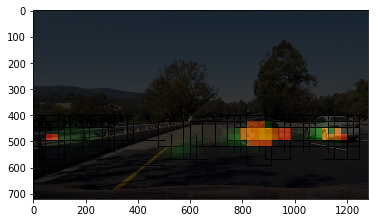

 77%|███████████████████████████████████████████████████████████████                   | 30/39 [00:41<00:12,  1.34s/it]

smooth_heatmap_max =  10.0


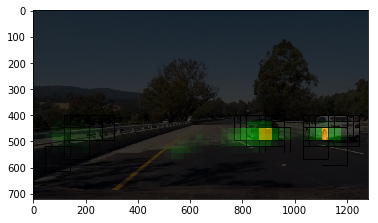

 79%|█████████████████████████████████████████████████████████████████▏                | 31/39 [00:42<00:10,  1.31s/it]

smooth_heatmap_max =  10.0


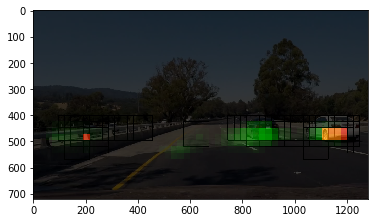

 82%|███████████████████████████████████████████████████████████████████▎              | 32/39 [00:43<00:09,  1.30s/it]

smooth_heatmap_max =  9.0


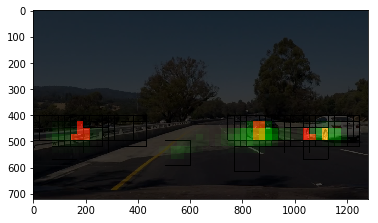

 85%|█████████████████████████████████████████████████████████████████████▍            | 33/39 [00:45<00:07,  1.28s/it]

smooth_heatmap_max =  11.0


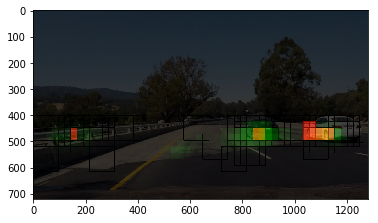

 87%|███████████████████████████████████████████████████████████████████████▍          | 34/39 [00:46<00:06,  1.28s/it]

smooth_heatmap_max =  10.0


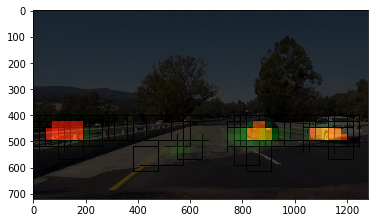

 90%|█████████████████████████████████████████████████████████████████████████▌        | 35/39 [00:47<00:05,  1.28s/it]

smooth_heatmap_max =  12.0


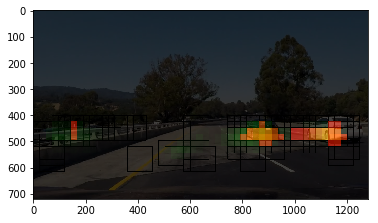

 92%|███████████████████████████████████████████████████████████████████████████▋      | 36/39 [00:49<00:03,  1.28s/it]

smooth_heatmap_max =  12.0


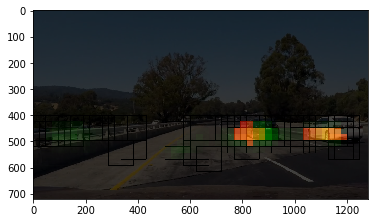

 95%|█████████████████████████████████████████████████████████████████████████████▊    | 37/39 [00:50<00:02,  1.27s/it]

smooth_heatmap_max =  12.0


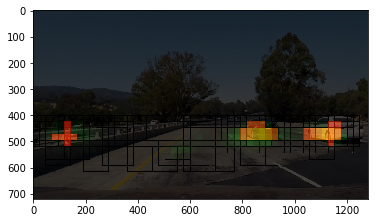

 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:51<00:01,  1.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 

Wall time: 54.1 s


In [11]:
from moviepy.editor import VideoFileClip

video_paths = (glob.glob('*video.mp4'))

for video_path in video_paths[-1],:#[-1::-1]:
    print(video_path)
    try:
        clip = VideoFileClip(video_path).fl_image(frame_prozessor.process_frame)
        %time clip.write_videofile(video_path[:-4] +'_result.mp4', audio=False)
    finally:
        clip.reader.__del__
        clip.__del__

# Discussion

Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?
	

Discussion includes some consideration of problems/issues faced, what could be improved about their algorithm/pipeline, and what hypothetical cases would cause their pipeline to fail. 


In [12]:
- Due to limited computing ressources just a prt of the dataset is used for training and normalizing
- try finetuning

SyntaxError: invalid syntax (<ipython-input-12-e92833fd1b68>, line 1)

# Suggestions to Make Your Project Stand Out!

A stand out submission for this project will be a pipeline that runs in near real time (at least several frames per second on a good laptop) and does a great job of identifying and tracking vehicles in the frame with a minimum of false positives. As an optional challenge, combine this vehicle detection pipeline with the lane finding implementation from the last project! As an additional optional challenge, record your own video and run your pipeline on it to detect vehicles under different conditions.
